Backends
---------------

First, we will set the backend for the plotting to be inline. This means that the plots will be interleaved with the text. This is very convenient for the tutorial. However, it lacks interactivity. If you would like to have interactivity, use one of the other options commented below. Note that, once you set the backend, you cannot change it unless you restart the kernel.

In [1]:
%matplotlib inline
# %matplotlib qt
# %matplotlib notebook



The [Raw](https://martinos.org/mne/stable/generated/mne.io.Raw.html) data structure: continuous data
=============================================================

Continuous data is stored in objects of type [Raw](https://martinos.org/mne/stable/generated/mne.io.Raw.html).
The core data structure is simply a 2D numpy array (channels × samples)
(in memory or loaded on demand) combined with an
[Info](https://martinos.org/mne/stable/generated/mne.Info.html#mne.Info) object (`.info` attribute)
(see [The Info data structure](https://martinos.org/mne/stable/auto_tutorials/plot_info.html#tut-info-objects)).



Loading continuous data
-----------------------

The most common way to load continuous data is from a .fif file. For more
information on [loading data from other formats](https://martinos.org/mne/stable/manual/io.html#ch-convert), or
creating it [from scratch](https://martinos.org/mne/stable/auto_tutorials/plot_creating_data_structures.html#tut-creating-data-structures).

Load an example dataset, the preload flag loads the data into memory now:



In [2]:
import mne
import os.path as op
from matplotlib import pyplot as plt

In [3]:
data_path = op.join(mne.datasets.sample.data_path(), 'MEG',
                    'sample', 'sample_audvis_raw.fif')
raw = mne.io.read_raw_fif(data_path, preload=True)
raw.set_eeg_reference('average', projection=True)  # set EEG average reference

Opening raw data file /home/mainak/Desktop/projects/github_repos/mne-python/examples/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Current compensation grade : 0
Reading 0 ... 166799  =      0.000 ...   277.714 secs...
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.


<Raw  |  sample_audvis_raw.fif, n_channels x n_times : 376 x 166800 (277.7 sec), ~482.1 MB, data loaded>

In [4]:
# Give the sample rate
print('sample rate:', raw.info['sfreq'], 'Hz')
# Give the size of the data matrix
print('%s channels x %s samples' % (len(raw), len(raw.times)))

sample rate: 600.614990234375 Hz
166800 channels x 166800 samples


**Note:**
This size can also be obtained by examining `raw._data.shape`.
However this is a private attribute as its name starts
with an `_`. This suggests that you should **not** access this
variable directly but rely on indexing syntax detailed just below.

Information about the channels contained in the [Raw](https://martinos.org/mne/stable/generated/mne.io.Raw.html)
object is contained in the [Info](https://martinos.org/mne/stable/generated/mne.Info.html#mne.Info) attribute.
This is essentially a dictionary with a number of relevant fields (see
[The Info data structure](https://martinos.org/mne/stable/auto_tutorials/plot_info.html#tut-info-objects)).



Indexing data
-------------

To access the data stored within [Raw]((https://martinos.org/mne/stable/generated/mne.io.Raw.html)) objects,
it is possible to index the [Raw](https://martinos.org/mne/stable/generated/mne.io.Raw.html) object.

Indexing a [Raw](https://martinos.org/mne/stable/generated/mne.io.Raw.html) object will 
return two arrays: 
* an array of times, 
* the data representing those timepoints. 
    
This works even if the data is _not preloaded_, in which case the data will be
read from disk when indexing.


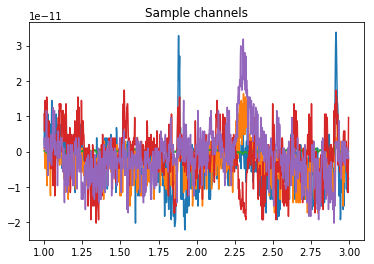

In [5]:
# Extract data from the first 5 channels, from 1 s to 3 s.
sfreq = raw.info['sfreq']
data, times = raw[:5, int(sfreq * 1):int(sfreq * 3)]
_ = plt.plot(times, data.T)
_ = plt.title('Sample channels')

Selecting subsets of channels and samples
-----------------------------------------

It is possible to use more intelligent indexing to extract data, using
channel names, types or time ranges.

Pull all MEG gradiometer channels:
Make sure to use .copy() or it will overwrite the data

In [6]:
meg_only = raw.copy().pick_types(meg=True)
eeg_only = raw.copy().pick_types(meg=False, eeg=True)

The MEG flag in particular lets you specify a string for more specificity

In [7]:
grad_only = raw.copy().pick_types(meg='grad')

Or you can use custom channel names

In [8]:
pick_chans = ['MEG 0112', 'MEG 0111', 'MEG 0122', 'MEG 0123']
specific_chans = raw.copy().pick_channels(pick_chans)
print(meg_only)
print(eeg_only)
print(grad_only)
print(specific_chans)

<Raw  |  sample_audvis_raw.fif, n_channels x n_times : 305 x 166800 (277.7 sec), ~391.7 MB, data loaded>
<Raw  |  sample_audvis_raw.fif, n_channels x n_times : 59 x 166800 (277.7 sec), ~78.2 MB, data loaded>
<Raw  |  sample_audvis_raw.fif, n_channels x n_times : 203 x 166800 (277.7 sec), ~261.7 MB, data loaded>
<Raw  |  sample_audvis_raw.fif, n_channels x n_times : 4 x 166800 (277.7 sec), ~8.1 MB, data loaded>


Notice the different scalings of these types



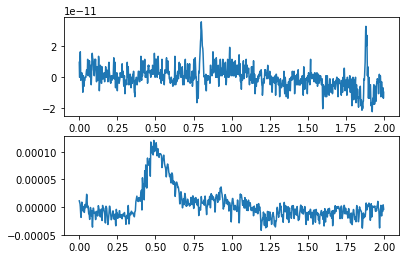

In [9]:
f, (a1, a2) = plt.subplots(2, 1)
eeg, times = eeg_only[0, :int(sfreq * 2)]
meg, times = meg_only[0, :int(sfreq * 2)]
a1.plot(times, meg[0])
a2.plot(times, eeg[0])
del eeg, meg, meg_only, grad_only, eeg_only, data, specific_chans

You can restrict the data to a specific time range



In [10]:
raw = raw.crop(0, 50)  # in seconds
print('New time range from', raw.times.min(), 's to', raw.times.max(), 's')

New time range from 0.0 s to 50.00041705299622 s


And drop channels by name



In [11]:
nchan = raw.info['nchan']
raw = raw.drop_channels(['MEG 0241', 'EEG 001'])
print('Number of channels reduced from', nchan, 'to', raw.info['nchan'])

Number of channels reduced from 376 to 374


Concatenating  [Raw](https://martinos.org/mne/stable/generated/mne.io.Raw.html) objects
--------------------------------------------------

[Raw](https://martinos.org/mne/stable/generated/mne.io.Raw.html) objects can be concatenated in time by using the
[raw.append](https://martinos.org/mne/dev/generated/mne.io.Raw.html#mne.io.Raw.append) function. For this to work, they must have the same number of channels and their [Info](https://martinos.org/mne/stable/generated/mne.Info.html#mne.Info) structures should be compatible.



In [12]:
# Create multiple Raw objects
raw1 = raw.copy().crop(0, 10)
raw2 = raw.copy().crop(10, 20)
raw3 = raw.copy().crop(20, 40)

# Concatenate in time (also works without preloading)
raw1.append([raw2, raw3])
print('Time extends from', raw1.times.min(), 's to', raw1.times.max(), 's')

Time extends from 0.0 s to 40.00399655463821 s


Visualizing Raw data
--------------------
All of the plotting method names start with `plot`. If you’re using IPython console, you can just
write `raw.plot` and ask the interpreter for suggestions with a tab key.

To visually inspect your raw data, you can use:

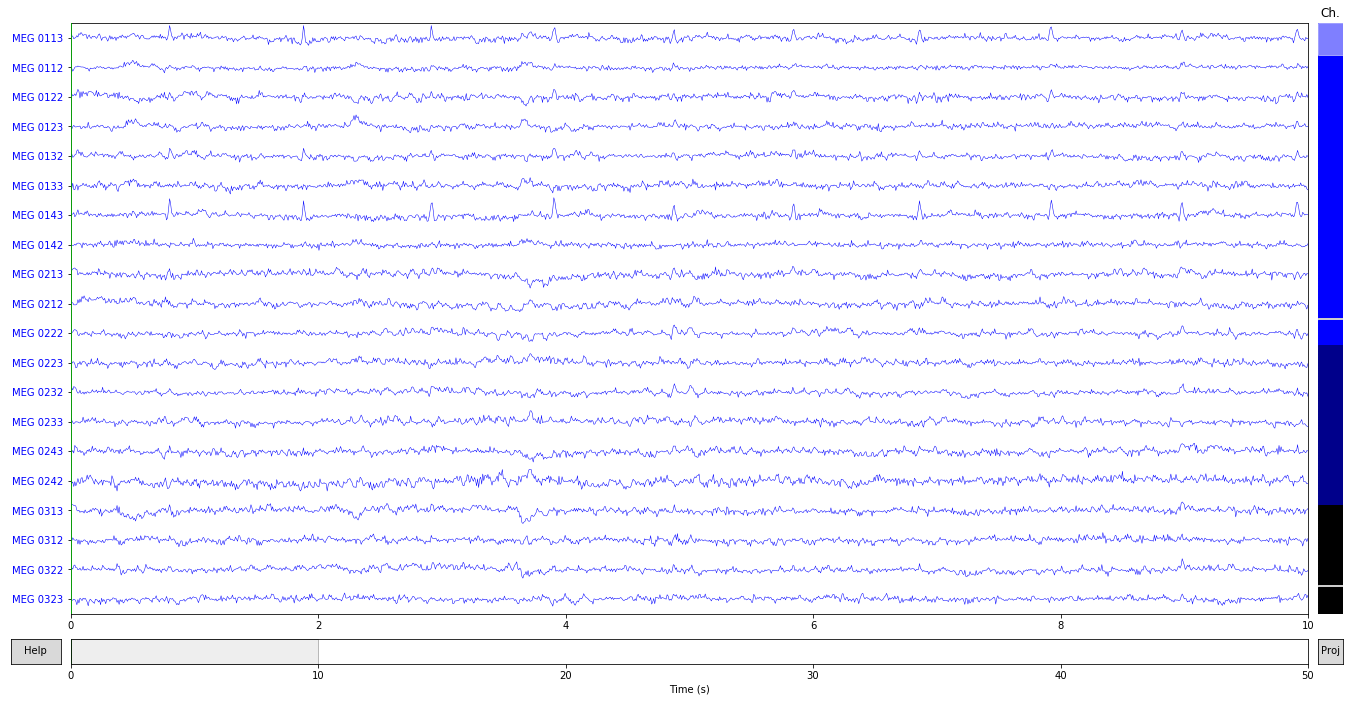

In [13]:
raw.plot(block=True, lowpass=40);

The channels are color coded by channel type. 
* MEG = blue, EEG = black
* Bad channels on scrollbar color coded gray. 
* Clicking the lines or channel names on the left, to mark or unmark a bad channel interactively. 
* +/- keys to adjust the scale (also = works for magnifying the data).
* Initial scaling factors can be set with parameter `scalings`. 
* If you don’t know the scaling factor for channels, you can automatically set them by passing scalings=’auto’. 
* With `pageup/pagedown` and `home/end` keys you can adjust the amount of data viewed at once.

We can also plot the PSD to inspect:
* Power line
* Bad channels
* Head position indicator coils
* Whether data is filtered or not

Effective window size : 3.410 (s)


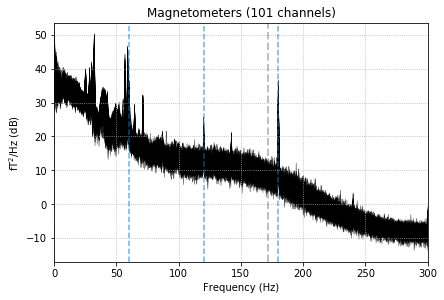

In [14]:
fig, ax = plt.subplots(1, 1)
raw.copy().pick_types(meg='mag').plot_psd(spatial_colors=False, show=False,
                                          ax=ax);
for freq in [60., 120., 180.]:
    ax.axvline(freq, linestyle='--', alpha=0.6)

Exercises
--------------

1) Quite often the EOG channel is not marked correctly in the raw data. You may need to rename it. Can you figure out how to do this?

In [15]:
# your code here

2) How will you check that at least one EEG channel exists in the data?

In [16]:
# your code here

3) Can you plot the data in the trigger channel?

*HINT*: The channel type is called 'stim'

In [17]:
from mne import pick_types
import matplotlib.pyplot as plt

# your code here